# Stopword Removal from Media Unit & Annotation

In this tutorial, we will show how *dimensionality reduction* can be applied over *both the media units and the annotations* of a crowdsourcing task, and how this impacts the results of the CrowdTruth quality metrics. We start with an *open-ended extraction task*, where the crowd was asked to highlight words or phrases in a text that identify or refer to people in a video. The task was executed on [FigureEight](https://www.figure-eight.com/). For more crowdsourcing annotation task examples, click [here](https://raw.githubusercontent.com/CrowdTruth-core/tutorial/getting_started.md).

To replicate this experiment, the code used to design and implement this crowdsourcing annotation template is available here: [template](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/People-Video-Highlight/template.html), [css](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/People-Video-Highlight/template.css), [javascript](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/People-Video-Highlight/template.js).

This is how the task looked like to the workers:

![Task Template](../img/person-video-highlight.png)

A sample dataset for this task is available in [this file](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/data/person-video-highlight.csv), containing raw output from the crowd on FigureEight. Download the file and place it in a folder named `data` that has the same root as this notebook. The answers from the crowd are stored in the `taggedinsubtitles` column.

In [1]:
import pandas as pd

test_data = pd.read_csv("../data/person-video-highlight.csv")
test_data["taggedinsubtitles"][0:30]

0     ["10,000 responses claimed she was wrong","onl...
1     ["10,000 responses","10,000","she was wrong","...
2     ["10,000","responses","claimed","she","was","w...
3                          ["a","princess","shut","up"]
4                          ["a","princess","shut","up"]
5                          ["a","princess","shut","up"]
6                          ["a","princess","shut","up"]
7                                      ["a","princess"]
8                  ["accent","talk","talking","actors"]
9                                            ["accent"]
10                                   ["actor","vowels"]
11                                   ["actor","vowels"]
12                                            ["actor"]
13                                            ["actor"]
14                                            ["actor"]
15                                            ["actor"]
16                                            ["actor"]
17                                            ["

Notice the diverse behavior of the crowd workers. While most annotated each word individually, the worker on *row 5* annotated chunks of the sentence together in one word phrase. Also, when no answer was picked by the worker, the value in the cell is `NaN`.

## A basic pre-processing configuration

Our basic pre-processing configuration attempts to normalize the different ways of performing the crowd annotations.

We set `remove_empty_rows = False` to keep the empty rows from the crowd. This configuration option will set all empty cell values to correspond to a *NONE* token in the annotation vector.

We build the annotation vector to have one component for each word in the sentence. To do this, we break up multiple-word annotations into a list of single words in the `processJudgments` call:

```
judgments[self.outputColumns[0]] = judgments[self.outputColumns[0]].apply(
            lambda x: str(x).replace(' ',self.annotation_separator))
```

The final configuration class `Config` is this:

In [2]:
import crowdtruth
from crowdtruth.configuration import DefaultConfig

class Config(DefaultConfig):
    inputColumns = ["ctunitid", "videolocation", "subtitles"]
    outputColumns = ["taggedinsubtitles"]
    open_ended_task = True
    annotation_separator = ","

    remove_empty_rows = False
    
    def processJudgments(self, judgments):
        # build annotation vector just from words
        judgments[self.outputColumns[0]] = judgments[self.outputColumns[0]].apply(
            lambda x: str(x).replace(' ',self.annotation_separator))

        # normalize vector elements
        judgments[self.outputColumns[0]] = judgments[self.outputColumns[0]].apply(
            lambda x: str(x).replace('[',''))
        judgments[self.outputColumns[0]] = judgments[self.outputColumns[0]].apply(
            lambda x: str(x).replace(']',''))
        judgments[self.outputColumns[0]] = judgments[self.outputColumns[0]].apply(
            lambda x: str(x).replace('"',''))
        return judgments

Now we can pre-process the data and run the CrowdTruth metrics:

In [3]:
data_with_stopwords, config_with_stopwords = crowdtruth.load(
    file = "../data/person-video-highlight.csv",
    config = Config()
)

processed_results_with_stopwords = crowdtruth.run(
    data_with_stopwords,
    config_with_stopwords
)

## Removing stopwords from Media Units and Annotations

A more complex dimensionality reduction technique involves removing the stopwords from both the *media units* and the crowd *annotations*. Stopwords (i.e. words that are very common in the English language) do not usually contain much useful information. Also, the behavior of the crowds w.r.t them is inconsistent - some workers omit them, some annotate them.

The first step is to build a function that removes stopwords from strings. We will use the `stopwords` corpus in the `nltk` package to get the list of words. We want to build a function that can be reused for both the text in the media units and in the annotations column. Also, we need to be careful about omitting punctuation.

The function `remove_stop_words` does all of these things:

In [4]:
import nltk
from nltk.corpus import stopwords
import string

stopword_set = set(stopwords.words('english'))
stopword_set.update(['s'])

def remove_stop_words(words_string, sep):
    '''
    words_string: string containing all words
    sep: separator character for the words in words_string
    '''

    words_list = words_string.replace("'", sep).split(sep)
    corrected_words_list = ""
    for word in words_list:
        if word.translate(None, string.punctuation) not in stopword_set:
            if corrected_words_list != "":
                corrected_words_list += sep
            corrected_words_list += word
    return corrected_words_list

In the new configuration class `ConfigDimRed`, we apply the function we just built to both the column that contains the media unit text (`inputColumns[2]`), and the column containing the crowd annotations (`outputColumns[0]`):

In [5]:
import pandas as pd

class ConfigDimRed(Config):
    def processJudgments(self, judgments):
        judgments = Config.processJudgments(self, judgments)
        
        # remove stopwords from input sentence
        for idx in range(len(judgments[self.inputColumns[2]])):
            judgments.at[idx, self.inputColumns[2]] = remove_stop_words(
                judgments[self.inputColumns[2]][idx], " ")
        
        for idx in range(len(judgments[self.outputColumns[0]])):
            judgments.at[idx, self.outputColumns[0]] = remove_stop_words(
                judgments[self.outputColumns[0]][idx], self.annotation_separator)
            if judgments[self.outputColumns[0]][idx] == "":
                judgments.at[idx, self.outputColumns[0]] = self.none_token
        return judgments

Now we can pre-process the data and run the CrowdTruth metrics:

In [6]:
data_without_stopwords, config_without_stopwords = crowdtruth.load(
    file = "../data/person-video-highlight.csv",
    config = ConfigDimRed()
)

processed_results_without_stopwords = crowdtruth.run(
    data_without_stopwords,
    config_without_stopwords
)

## Effect on CrowdTruth metrics

Finally, we can compare the effect of the stopword removal on the CrowdTruth *sentence quality score*.

Text(0,0.5,'without stopwords')

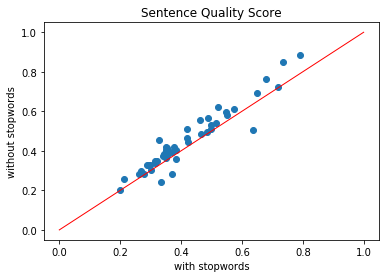

In [7]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.scatter(
    processed_results_with_stopwords["units"]["uqs"],
    processed_results_without_stopwords["units"]["uqs"],
)
plt.plot([0, 1], [0, 1], 'red', linewidth=1)
plt.title("Sentence Quality Score")
plt.xlabel("with stopwords")
plt.ylabel("without stopwords")

The red line in the plot runs through the diagonal. All sentences above the line have a higher *sentence quality score* when the stopwords were removed.

The plot shows that removing the stopwords improved the quality for a majority of the sentences. Surprisingly though, some sentences decreased in quality. This effect can be understood when plotting the *worker quality scores*.

Text(0,0.5,'without stopwords')

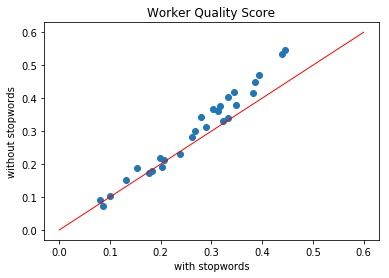

In [8]:
plt.scatter(
    processed_results_with_stopwords["workers"]["wqs"],
    processed_results_without_stopwords["workers"]["wqs"],
)
plt.plot([0, 0.6], [0, 0.6], 'red', linewidth=1)
plt.title("Worker Quality Score")
plt.xlabel("with stopwords")
plt.ylabel("without stopwords")

The quality of the majority of workers also has increased in the configuration where we removed the stopwords. However, because of the inter-linked nature of the CrowdTruth quality metrics, the annotations of these workers now has a greater weight when calculating the *sentence quality score*. So the stopword removal process had the effect of removing some of the noise in the annotations and therefore increasing the quality scores, but also of *amplifying the true ambiguity in the sentences*.

In [11]:
processed_results_with_stopwords["units"].to_csv("../data/results/openextr-persvid-units.csv")
processed_results_with_stopwords["workers"].to_csv("../data/results/openextr-persvid-workers.csv")

processed_results_without_stopwords["units"].to_csv("../data/results/openextr-persvid-dimred-units.csv")
processed_results_without_stopwords["workers"].to_csv("../data/results/openextr-persvid-dimred-workers.csv")

To further explore the CrowdTruth quality metrics, download the aggregation results in ```.csv``` format for:

* [units with stopwords](https://github.com/CrowdTruth/CrowdTruth-core/blob/master/tutorial/data/results/openextr-persvid-units.csv)
* [workers with stopwords](https://github.com/CrowdTruth/CrowdTruth-core/blob/master/tutorial/data/results/openextr-persvid-workers.csv)
* [units without stopwords](https://github.com/CrowdTruth/CrowdTruth-core/blob/master/tutorial/data/results/openextr-persvid-dimred-units.csv)
* [workers without stopwords](https://github.com/CrowdTruth/CrowdTruth-core/blob/master/tutorial/data/results/openextr-persvid-dimred-workers.csv)